## 背景
我们知道，我国的汽车牌照由各省的简称 + 24 个英文字母（由于字母不包括I和O）+ 0~9 自由组合而成，因此，训练出能识别这些汉字，字母和数字的深度学习模型成为可能。而汽车牌照识别的原理，这里主要分为三大步：
1. 图像处理
2. 深度学习字符识别模型
3. 文字转语音

## 一、图像处理
主要使用 OpenCV 进行图像的处理工作，包括图像的模糊，形态学处理，车牌图像的提取以及字符图片的分割。



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1、读取图像

(-0.5, 399.5, 299.5, -0.5)

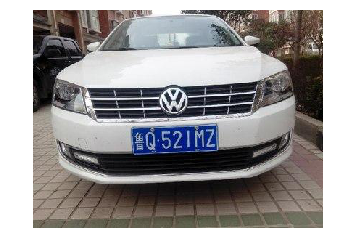

In [2]:
img_file = "../dataset/test/car3.jpg"
img = cv2.imread(img_file)
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # cv2默认是以BGR的格式进行图片的读取的
plt.imshow(img_show)
plt.axis("off")

### 2、图像降噪
使用高斯模糊对图像进行降噪

(-0.5, 399.5, 299.5, -0.5)

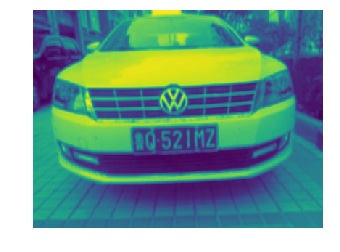

In [3]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gauss_img = cv2.GaussianBlur(gray_img, (5, 5), 0, 0, cv2.BORDER_DEFAULT)
plt.imshow(gauss_img)
plt.axis("off")

### 3、定位车牌位置
1. 先使用较大的 kernel 对图片执行开运算（先腐蚀，后膨胀），使得车牌区域变成连通的一片。

(-0.5, 399.5, 299.5, -0.5)

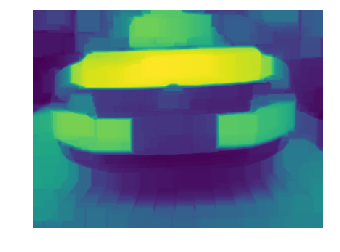

In [4]:
kernal = np.ones((23, 23), np.uint8)
img_opening = cv2.morphologyEx(gauss_img, cv2.MORPH_OPEN, kernal)
plt.imshow(img_opening)
plt.axis("off")

2. 执行顶帽运算（原图像 - 开运算图像），可以突出原图像中比周围亮的区域

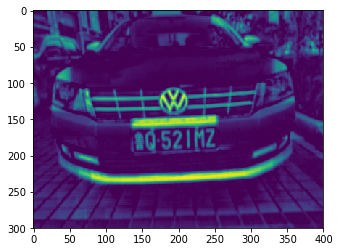

In [5]:
img_top_hat = cv2.addWeighted(gauss_img, 1, img_opening, -1, 0)
plt.imshow(img_top_hat)

3. 找到图像的边缘

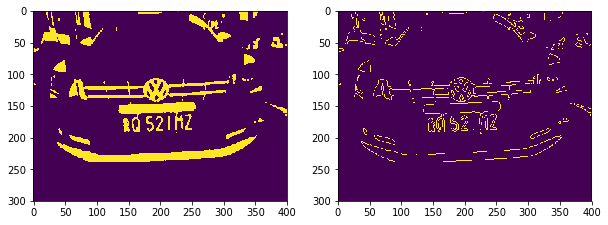

In [6]:
ret, img_thresh = cv2.threshold(img_top_hat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
img_edge = cv2.Canny(img_thresh, 100, 200)
fig, axes = plt.subplots(1, 2, figsize = (10, 8))
axes[0].imshow(img_thresh)
axes[1].imshow(img_edge)

4. 使用闭运算和开运算使边缘成为一个整体  
闭运算（先膨胀后腐蚀），使得临近的亮像素点连成一片。执行完闭运算之后再执行开运算，可以消除图片中非成片的亮点。

Text(0.5, 1.0, 'edge image with morph open')

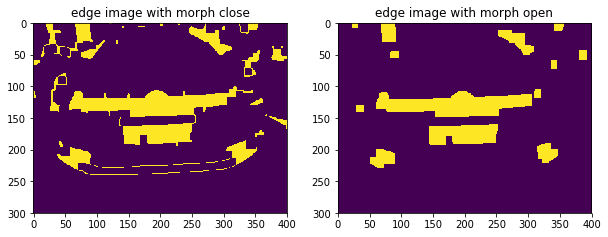

In [7]:
kernel = np.ones((10, 10), np.uint8)
img_edge_close = cv2.morphologyEx(img_edge, cv2.MORPH_CLOSE, kernel)
img_edge_open = cv2.morphologyEx(img_edge_close, cv2.MORPH_OPEN, kernel)
fig, axes = plt.subplots(1, 2, figsize = (10, 8))
axes[0].imshow(img_edge_close)
axes[0].set_title("edge image with morph close")
axes[1].imshow(img_edge_open)
axes[1].set_title("edge image with morph open")

5. 查找图像边缘整体形成的矩形区域，在图片中可能有很多个矩形区域，车牌的区域就是其中的一个。为了得到正确的车牌区域，需要设计一系列筛选的规则对找到的边缘进行筛选。  
a. 车牌区域的面积在一个合适的范围内  
b. 车牌区域的长宽比在一个合适的范围内  
c. 车牌的颜色（目前只识别蓝、黄、绿的车牌）

In [8]:
# 使用车牌区域的面积进行筛选
min_area = 500
max_area = 2000
img_contour, contours, hierarchy = cv2.findContours(img_edge_open, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
print("number of contours selected: ", len(contours))

number of contours selected:  6


In [9]:
# 使用车牌区域的长宽比进行筛选
min_ratio = 2
max_ratio = 5.5
plate_contours = []
for cnt in contours:
    """
    cv2.minAreaRect()的返回值为：((center.x, center.y), (width, height), angle),
    其中 angle 的范围为 -90 ~ 0 °,angle 的计算方法是水平轴 x 逆时针旋转，与矩形
    第一条边相遇时转过的角度
    """
    rect = cv2.minAreaRect(cnt)       # 找到包围每个边缘点集的最小矩形
    area_width, area_height = rect[1]
    if area_width < area_height:      # 保证较长的边为宽
        area_width, area_height = area_height, area_width
    wh_ratio = area_width / area_height
    if wh_ratio > min_ratio and wh_ratio < max_ratio:
        plate_contours.append(rect)   # 保存可能为车牌区域的最小外接矩形
print("number of contours selected: ", len(plate_contours))

number of contours selected:  2


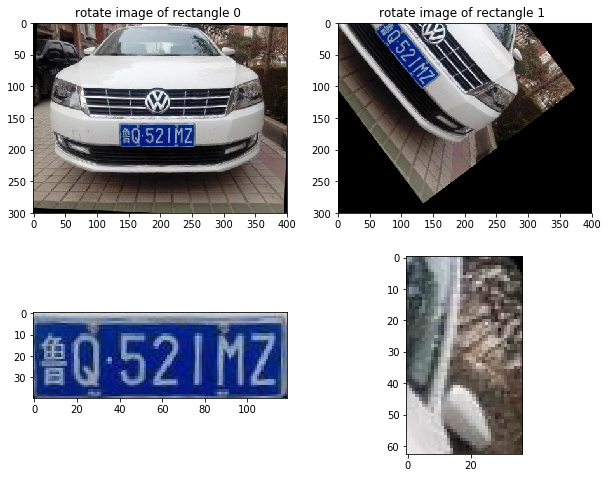

In [69]:
# 将上面找到的最小外接矩形所包含的图片区域提取出来，以便进行下一步的筛选
# 因为最小外接矩形是有角度的，不一定是平行的矩形，所以先要将图片进行旋转，使最小外接矩形平行
plate_rois = []
h, w = img.shape[:2]
fig, axes = plt.subplots(2, len(plate_contours), figsize = (10, 8))
index = 0
for rect in plate_contours:
    angle = rect[2]
    # 需要注意的是当使用 getRotationMatrix2D()进行旋转的时候，逆时针旋转角度为正，顺时针为负
    # 而 rect 中的 angle，逆时针为负
    rotate_matrix = cv2.getRotationMatrix2D(rect[0], angle, scale = 1)
    rotate_img = cv2.warpAffine(img, rotate_matrix, img.shape[1::-1])    # 将原始图片进行旋转
    axes[0][index].imshow(cv2.cvtColor(rotate_img, cv2.COLOR_BGR2RGB))      # 绘制旋转调整之后的图像
    axes[0][index].set_title("rotate image of rectangle %d "%(index))
    
    center_y = rect[0][1]
    center_x = rect[0][0]
    width = rect[1][0]
    height = rect[1][1]
    # 在取 ROI 时要多取一点，防止没有取全
    plate_roi = rotate_img[max(0, int(center_y - height/2)-5): min(h, int(center_y + height/2)+5), 
                           max(0, int(center_x - width / 2)-5): min(w, int(center_x + width / 2)+5), 
                           :]
    axes[1][index].imshow(cv2.cvtColor(plate_roi, cv2.COLOR_BGR2RGB))
    plate_rois.append(plate_roi)
    index += 1


number of plate images:  1


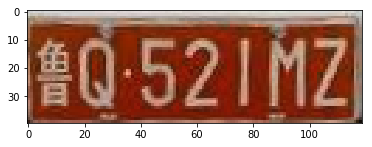

In [92]:
"""
使用颜色对车牌区域进行识别
使用HSV模型来表示图片，当H表示图片的色调，S表示饱和度，V表示亮度
Orange  0-22
Yellow 22- 38
Green 38-75
Blue 75-130
Violet 130-160
Red 160-179
"""
plate_img = []
for plate_roi in plate_rois:
    hsv_plate = cv2.cvtColor(plate_roi, cv2.COLOR_BGR2HSV)
    height, width, channels = hsv_plate.shape[:]
    h_plate = hsv_plate[:, :, 0]
    yellow = 0
    green = 0
    blue = 0
    color_thresh = width * height / 2
    for row in range(height):
        for col in range(width):
            if h_plate[row][col] > 22 and h_plate[row][col] < 38:
                yellow += 1
            elif h_plate[row][col] > 38 and h_plate[row][col] < 75:
                green += 1
            elif h_plate[row][col] > 75 and h_plate[row][col] < 130:
                blue += 1
    if yellow > color_thresh and yellow > max(green, blue):
        plate_img.append([plate_roi, 'yellow'])
    elif green > color_thresh and green > max(yellow, blue):
        plate_img.append([plate_roi, 'green'])
    elif blue > color_thresh and blue > max(yellow, green):
        plate_img.append([plate_roi, 'blue'])
    
#     _yellow = np.where(np.where(h_plate > 22, h_plate, 0) < 38, 1, 0).sum()
#     _green = np.where(np.where(h_plate > 38, h_plate, 0) < 75, 1, 0).sum()
#     _blue = np.where(np.where(h_plate > 75, h_plate, 0) < 130, 1, 0).sum()
#     if max(_yellow, _green, _blue) > width * height / 4:
#         print(max(_yellow, _green, _blue), width * height)
#         plate_img

print("number of plate images: ", len(plate_img))
plt.imshow(plate_img[0][0])